In [30]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from PIL import Image
from PIL import ImageDraw
plt.style.use({'figure.figsize':(10, 10)})

# Q-Table One

### Q-table One is used to void the obstacles automatically.
### Columns:Nearest|Near|Medium|Far
##### Columns register the states
### Rows:Up|Down|Turn_left_45 degree|Turn_right_45_degree
##### Rows register the actions

In [31]:
#constant
Epsilon_start=1
Epsilon_final=0.01
Decay_Rate=0.000001#he dacaying rate of the Epsilon, the range of the epsilon is 0.01-1, initially it is 1.
Action_times=0 #Rigister the totality of the times of selecting actions, including the random selections and selection based on Q_Table
Velocity_tripod=0.289*40
Up_D=np.array([-40,-20,0,20,40])
Left_D=np.array([-60,-80,-100,-120])
Right_D=np.array([60,80,100,120])
Robot_R=40
Beta=0.9
Alpha=0.2

In [32]:
#Nearest(<50cm)||Near(50cm-130cm)||Medium(130cm-210cm)|Far(>210cm)
#Safe distance=1cm
States=np.array(['L0R0U0','L0R0U1','L0R0U2','L0R0U3',
                'L0R1U0','L0R1U1','L0R1U2','L0R1U3',
                'L0R2U0','L0R2U1','L0R2U2','L0R2U3',
                'L0R3U0','L0R3U1','L0R3U2','L0R3U3',
                'L1R0U0','L1R0U1','L1R0U2','L1R0U3',
                'L1R1U0','L1R1U1','L1R1U2','L1R1U3',
                'L1R2U0','L1R2U1','L1R2U2','L1R2U3',
                'L1R3U0','L1R3U1','L1R3U2','L1R3U3',
                'L2R0U0','L2R0U1','L2R0U2','L2R0U3',
                'L2R1U0','L2R1U1','L2R1U2','L2R1U3',
                'L2R2U0','L2R2U1','L2R2U2','L2R2U3',
                'L2R3U0','L2R3U1','L2R3U2','L2R3U3',
                'L3R0U0','L3R0U1','L3R0U2','L3R0U3',
                'L3R1U0','L3R1U1','L3R1U2','L3R1U3',
                'L3R2U0','L3R2U1','L3R2U2','L3R2U3',
                'L3R3U0','L3R3U1','L3R3U2','L3R3U3'])
Actions=np.array(['Up','Down','Left_45D','Right_45D'])
Actions_len=len(Actions)
States_len=len(States)
# print(Actions_len)
# print(States_len)

In [33]:
Q_Table_Real=np.zeros((States_len,Actions_len))
Q_Table_Real=pd.DataFrame(Q_Table_Real,columns=Actions,index=States)
Q_Table_Real.head()

,Up,Down,Left_45D,Right_45D
L0R0U0,0.0,0.0,0.0,0.0
L0R0U1,0.0,0.0,0.0,0.0
L0R0U2,0.0,0.0,0.0,0.0
L0R0U3,0.0,0.0,0.0,0.0
L0R1U0,0.0,0.0,0.0,0.0


In [34]:
def Initial_Q_Table(Actions_len_,States_len_):
    Q_Table_=np.zeros((States_len_,Actions_len_))
    print('***********************************************************')
    print("Succeed to initialize Q-Table!")
    print('***********************************************************')
    return Q_Table_
Q_Table=Initial_Q_Table(Actions_len,States_len)
print(Q_Table.shape)
print(Q_Table[:10])

***********************************************************
Succeed to initialize Q-Table!
***********************************************************
(64, 4)
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]


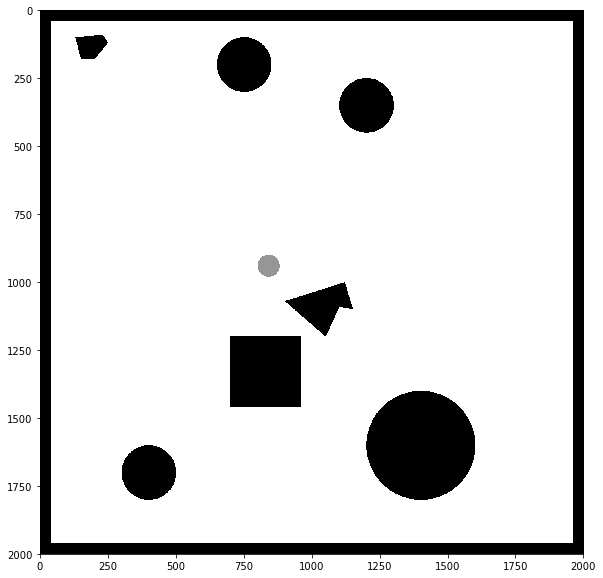

In [35]:
#Draw_map1 funcion is used to train the first Q-Table, which allows it to avoid obstacles
im = Image.new("I", size=(2000,2000),color=0) #Color means the degree of Gray scale, 255 means white, 0 means black
draw = ImageDraw.Draw(im,mode='I') #mode="I" means the made degree of Gray scale
#Draw the black frame around the rectangle
draw.rectangle((40,40,1960,1960),255,255)  #the last elements means the color of the inner graph and that of the outer frame
def Draw_map1():
    draw.ellipse((800,900,880,980),150, 150)
    draw.rectangle((1500,1000,1600,1100),0, 0) 
    draw.ellipse((400,700,600,900),0, 0) 
    draw.rectangle((200,300,500,600),0, 0) 
    draw.ellipse((1500,500,1800,800),0, 0) 
    draw.ellipse((1200,1400,1600,1800),0, 0) 
    draw.rectangle((700,1200,960,1460),0, 0) 
    draw.ellipse((300,1600,500,1800),0, 0) 
    draw.rectangle((100,1100,300,1300),0, 0) 
    draw.ellipse((1100,250,1300,450),0, 0) 
    draw.polygon((900, 1070,1120, 1000,1150, 1100, 1100,1090,1050, 1200), 0, 0)
    draw.pieslice((750, 1700, 950, 1900), 0,180,0,0)
    draw.ellipse((900,550,1050,700),0, 0)
    draw.ellipse((650,100,850,300),0, 0) 
    draw.rectangle((1700,130,1900,330),0, 0)
    draw.polygon((150, 180, 200, 180, 250, 120, 230, 90, 130, 100), 0, 0)
Draw_map1()
plt.imshow(im)
plt.show()

In [36]:
#Function Scan is used to detect the distance between obstacles and robot.
#Nearest(<50cm)||Near(50cm-130cm)||Medium(130cm-210cm)|Far(>210cm)
#Furthest scanning distance is defined as 290cm
def Scan(Current_x,Current_y,Angle):
    Dis_level=0
    Obs_dis=Robot_R
    Obs_line_x=[]
    Obs_line_y=[]
    Obs_dis_x=Current_x+Obs_dis*np.cos(Angle/180*np.pi)
    Obs_dis_y=Current_y+Obs_dis*np.sin(Angle/180*np.pi)
    while(im.getpixel((Obs_dis_x,Obs_dis_y))!=0 and Obs_dis<250):#getpixiel obtains the degree of Gray Scale
        Obs_dis+=5  #Search interval, can be changed
        Obs_dis_x=Current_x+Obs_dis*np.cos(Angle/180*np.pi)
        Obs_line_x.append(Obs_dis_x)
        Obs_dis_y=Current_y+Obs_dis*np.sin(Angle/180*np.pi)
        Obs_line_y.append(Obs_dis_y)
    if 0<=Obs_dis<90:
        dis_level=0 #Nearear
    elif 90<=Obs_dis<170:
        dis_level=1 #Near
    elif 170<=Obs_dis<250:
        dis_level=2 #Medium
    else:
        dis_level=3 #Far
#     Obs_line_xy=list(zip(Obs_line_x,Obs_line_y))
#     draw.line(Obs_line_xy, width=12)
    return dis_level
# print(Scan(1133,1408,20))
# plt.imshow(im)
# plt.show()

In [37]:
def Is_Crash(Current_x_,Current_y_):
    Crash_=False
    Degree=[-150,-120,-90,-60,-30,0,30,60,90,120,150,180]
    Dis=np.arange(0,50,5)
    for i in Dis:
        for j in Degree:
            x_=Current_x_+i*np.cos(j/180*np.pi)
            y_=Current_y_+i*np.sin(j/180*np.pi)
            if (im.getpixel((x_,y_)))==0:
                Crash_=True
                break
        if Crash_==True:
                break
    return Crash_

In [38]:
def Random_start():
    Angle_=0
    x_,y_=np.random.random(2)*2000
    while(Is_Crash(x_,y_)==True):
#         print('Boom')
        x_,y_=np.random.random(2)*2000
    return x_,y_,Angle_
print(Random_start())

(250.48007726893707, 1063.0243248763127, 0)


In [39]:
LRU=[] #LRU register to maximum values of up, left, right.
def Direction_min_level(Degree,Current_x,Current_y,Rotbot_angle):
    Level=[]
    Degree=Degree+Rotbot_angle
    for i in Degree:
        Level.append(Scan(Current_x,Current_y,i))
    return min(Level)
# Left_min=Direction_min_level(Left_D,1133,1408)
# Right_min=Direction_min_level(Right_D,1133,1408) 
# Up_min=Direction_min_level(Up_D,1133,1408)

In [40]:
def Output_state_index(Left_min_,Right_min_,Up_min_):
    LRU=[]
    LRU.append(Left_min_)
    LRU.append(Right_min_)
    LRU.append(Up_min_)
    return LRU[0]*16+LRU[1]*4+LRU[2]
# print(Output_state_index(Left_min,Right_min,Up_min))

In [41]:
#Choose_action is used to selection an action during the training process. It is based on the greedy strategy, if the random 
#chosen float(0-1) is inferior to current epsilon, robot choose random action to explore, if not, choose maximun Q value
#action based on Q Table, more precisely based on the action-state range
def Choose_action(Q_Table_,Current_state_,Action_times_):
    Epsilon=Epsilon_final+(Epsilon_start-Epsilon_final)*np.exp(-1*Decay_Rate*Action_times_)
    State_action_=Q_Table_[Current_state_,:]
    if(np.random.random()<Epsilon or np.all(State_action_==[0])):
        Action_next=np.random.randint(Actions_len)
    else:
        Action_next=np.argmax(State_action_)
    return Action_next
#print(Choose_action(Q_Table,20,0))

In [42]:
def Next_state_F(Current_x_,Current_y_,Action_,Robot_angle_):
    R=1
    Crash_=False
    if Action_==0:
        Next_x_=Current_x_+Velocity_tripod*np.cos(Robot_angle_/180*np.pi)
        Next_y_=Current_y_+Velocity_tripod*np.sin(Robot_angle_/180*np.pi)
#         print(Next_x_)
#         print(Next_y_)
        if Is_Crash(Next_x_, Next_y_)==True:
            Crash_=True
            R=-50
    elif Action_==1:
        Next_x_=Current_x_-Velocity_tripod*np.cos(Robot_angle_/180*np.pi)
        Next_y_=Current_y_-Velocity_tripod*np.sin(Robot_angle_/180*np.pi)
        if Is_Crash(Next_x_, Next_y_)==True:
            Crash_=True
            R=-50
    elif Action_==2:
        Robot_angle_=Robot_angle_-45
        Next_x_=Current_x_
        Next_y_=Current_y_
    elif Action_==3:
        Robot_angle_=Robot_angle_+45
        Next_x_=Current_x_
        Next_y_=Current_y_
    return Next_x_,Next_y_,R,Robot_angle_,Crash_

In [43]:
#     Obs_line_xy=list(zip(Obs_line_x,Obs_line_y))
#     draw.line(Obs_line_xy, width=12)
def Plot_Move(Vec_x_,Vec_y_):
    im1=Image.new("I", size=(2000,2000),color=0)
    draw1 = ImageDraw.Draw(im1,mode='I')
    draw1.rectangle((40,40,1960,1960),255,255)
    draw1.ellipse((800,900,880,980),150, 150)
    draw1.rectangle((1500,1000,1600,1100),0, 0) 
    draw1.ellipse((400,700,600,900),0, 0) 
    draw1.rectangle((200,300,500,600),0, 0) 
    draw1.ellipse((1500,500,1800,800),0, 0) 
    draw1.ellipse((1200,1400,1600,1800),0, 0) 
    draw1.rectangle((700,1200,960,1460),0, 0) 
    draw1.ellipse((300,1600,500,1800),0, 0) 
    draw1.rectangle((100,1100,300,1300),0, 0) 
    draw1.ellipse((1100,250,1300,450),0, 0) 
    draw1.polygon((900, 1070,1120, 1000,1150, 1100, 1100,1090,1050, 1200), 0, 0)
    draw1.pieslice((750, 1700, 950, 1900), 0,180,0,0)
    draw1.ellipse((900,550,1050,700),0, 0)
    draw1.ellipse((650,100,850,300),0, 0) 
    draw1.rectangle((1700,130,1900,330),0, 0)
    draw1.polygon((150, 180, 200, 180, 250, 120, 230, 90, 130, 100), 0, 0)
    draw1.ellipse((Vec_x_[0]-40,Vec_y_[0]-40, Vec_x_[0]+40,Vec_y_[0]+40),5,5) 
    for i,j in zip(Vec_x_[1:],Vec_y_[1:]):
        draw1.ellipse((i-40,j-40, i+40,j+40),150,150) 
    plt.imshow(im1)
    plt.show()
    del draw1
    del im1

In [44]:
Q_Table=Initial_Q_Table(Actions_len,States_len)
global Epoche
Epoche=0
global Action_times #Rigister the totality of the times of selecting actions, including the random selections and selection based on Q_Table
Action_times=0
global Epoche_action_interval
Epoche_action_interval=[]

***********************************************************
Succeed to initialize Q-Table!
***********************************************************



***********************************************************
Epoche
0
Action_times
517
Epsilon
0.999488302285


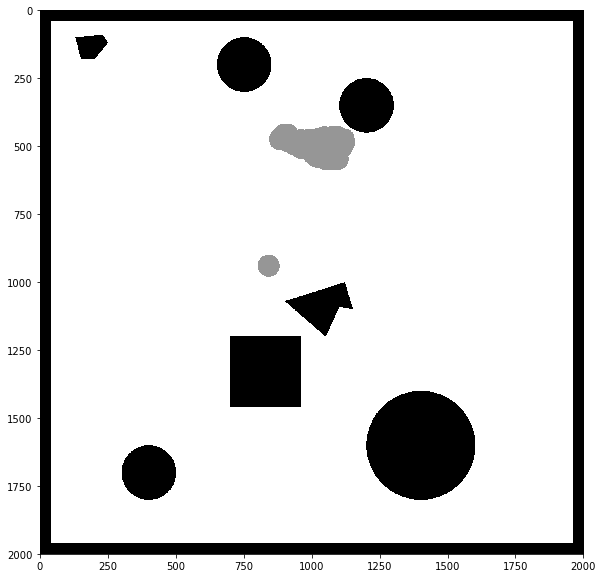

***********************************************************
Epoche
10
Action_times
23978
Epsilon
0.976544116397


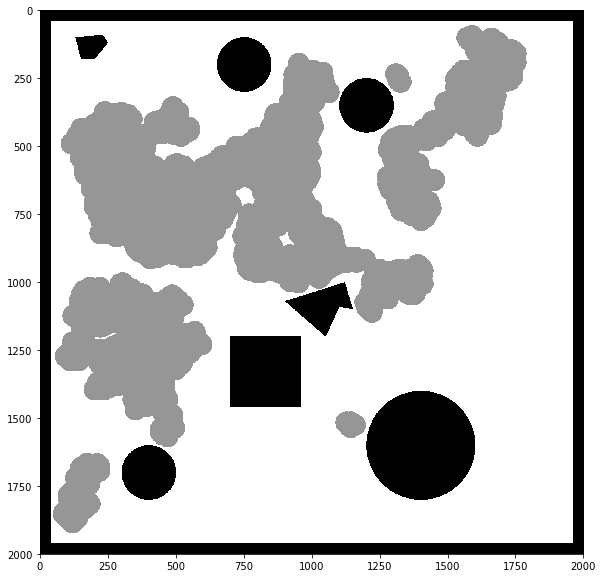

***********************************************************
Epoche
20
Action_times
40823
Epsilon
0.960399044393


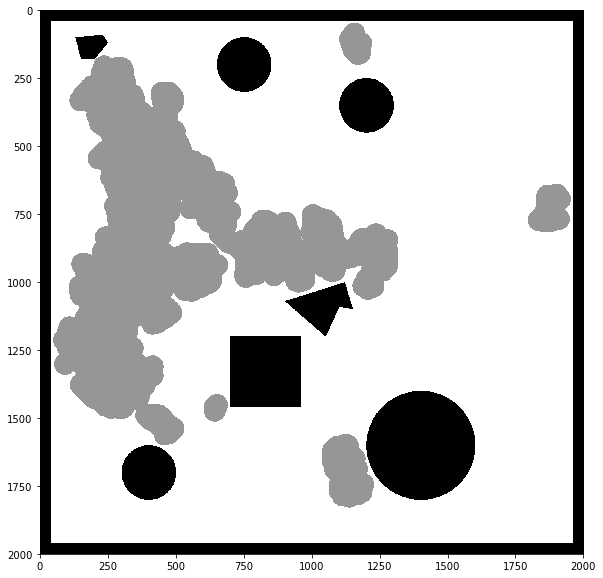

***********************************************************
Epoche
30
Action_times
104279
Epsilon
0.90196415173


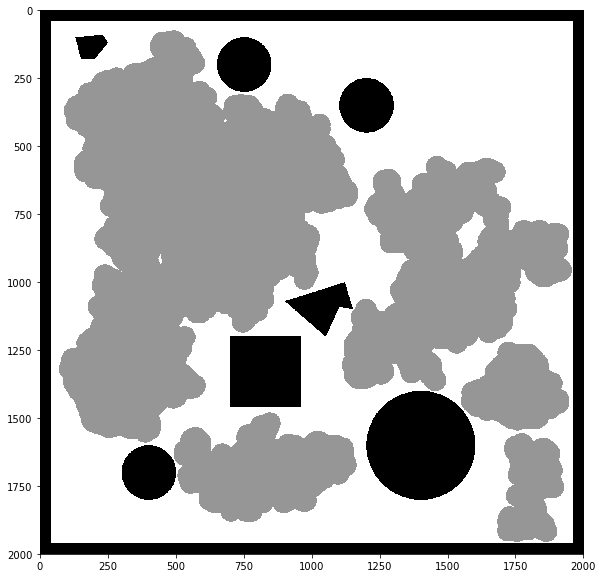

KeyboardInterrupt: 

In [45]:
def Run1():
    global Epoche
    global Action_times
    global Epoche_action_interval
    Crash=False
    Current_x,Current_y,Current_a=Random_start()
    Epoche_false=0
    Vec_x=[]
    Vec_y=[]
    Vec_x.append(Current_x)
    Vec_y.append(Current_y)
    Epoche_action_times=0
    while Epoche_false<100:
        Current_Left_Obs_Lev=Direction_min_level(Left_D,Current_x,Current_y,Current_a)
        Current_Right_Obs_Lev=Direction_min_level(Right_D,Current_x,Current_y,Current_a)
        Current_Up_Obs_Lev=Direction_min_level(Up_D,Current_x,Current_y,Current_a)
        Current_state=Output_state_index(Current_Left_Obs_Lev,Current_Right_Obs_Lev,Current_Up_Obs_Lev)
        
        Action_next=Choose_action(Q_Table,Current_state,Action_times)
        Next_x,Next_y,R,Next_a,Crash=Next_state_F(Current_x,Current_y,Action_next,Current_a)
        
        if Crash==True:
            Q_target=R
            if(Epoche%10==0):
                print('***********************************************************')
                print('Epoche')
                print(Epoche)
                print("Action_times")
                print(Action_times)
                print("Epsilon")
                print(Epsilon_final+(Epsilon_start-Epsilon_final)*np.exp(-1*Decay_Rate*Action_times))
                Plot_Move(Vec_x,Vec_y)
                Vec_x=[]
                Vec_y=[]
            Epoche+=1
            Epoche_false+=1
            Next_x,Next_y,Next_a=Random_start()
            Epoche_action_interval.append(Epoche_action_times)
            Epoche_action_times=0
        
        else:
            Next_Left_Obs_Lev=Direction_min_level(Left_D,Next_x,Next_y,Next_a)
            Next_Right_Obs_Lev=Direction_min_level(Right_D,Next_x,Next_y,Next_a)
            Next_Up_Obs_Lev=Direction_min_level(Up_D,Next_x,Next_y,Next_a)
            Next_state=Output_state_index(Next_Left_Obs_Lev,Next_Right_Obs_Lev,Next_Up_Obs_Lev)
            Q_target=R+Beta*max(Q_Table[Next_state])
            
        Q_Table[Current_state][Action_next]+=Alpha*(Q_target-Q_Table[Current_state][Action_next])
        Current_x=Next_x
        Current_y=Next_y
        Current_a=Next_a
        Vec_x.append(Current_x)
        Vec_y.append(Current_y)
        Action_times+=1
        Epoche_action_times+=1
    plt.plot(np.arange(len(Epoche_action_interval)),Epoche_action_interval)
    return Q_Table
print()
Q_Table_Final=Run1()
Q_Table_Final=pd.DataFrame(Q_Table_Final,columns=Actions,index=States)
Q_Table_Final


In [ ]:
def test(Q_Table_):
    Crash=False
    Current_x,Current_y,Current_a=Random_start()
    Test_time=0
    Vec_x=[]
    Vec_y=[]
    print(Vec_x)
    while Test_time<10000:
        Current_Left_Obs_Lev=Direction_min_level(Left_D,Current_x,Current_y,Current_a)
        Current_Right_Obs_Lev=Direction_min_level(Right_D,Current_x,Current_y,Current_a)
        Current_Up_Obs_Lev=Direction_min_level(Up_D,Current_x,Current_y,Current_a)
        Current_state=Output_state_index(Current_Left_Obs_Lev,Current_Right_Obs_Lev,Current_Up_Obs_Lev)
        Action_next=np.argmax(Q_Table_[Current_state])
#         print('Current_state')
#         print(Current_state)
#         print('Action_next')
#         print(Action_next)
        Next_x,Next_y,R,Next_a,Crash=Next_state_F(Current_x,Current_y,Action_next,Current_a)
#         print(Current_a%360)
        
        Vec_x.append(Current_x)
        Vec_y.append(Current_y)
        if Crash==True:
            print('Boom')
            print(Test_time)
            break
        else:
            if(Test_time%1000==0):
                Plot_Move(Vec_x,Vec_y)
                Vec_x=[]
                Vec_y=[]
                Next_x,Next_y,Current_a=Random_start()
                print("******************")
                print()
#                 print(im.getpixel((Mext_x,Next_y)))
                print(Test_time)
                print("******************")
        Current_x=Next_x
        Current_y=Next_y
        Current_a=Next_a
        Test_time+=1
test(Q_Table_Final.as_matrix())
np.savetxt("Q_Table.txt",Q_Table_Final.as_matrix())
            

In [ ]:
Q_Table_Final.iloc[30,:]

In [ ]:
np.array([1,1,1])+2